# Setup

## Packages

In [ ]:
# data analysis
import scanpy as sc
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patches
from matplotlib.path import Path

## Functions

### scatterplots

#### shuffled embedding

In [17]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=8,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=20,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

### barplots

In [18]:
def get_dataframe_barplot(
    adata,
    groupby,
    color_var: str | None = None,
    *,
    normalize_groupby: bool = True,
    normalize_color_var: bool = True,
    percent: bool = True,
) -> pd.DataFrame:
    df = sc.get.obs_df(
        adata=adata,
        keys=[groupby, color_var],
    )

    df = (
        df.groupby([groupby, color_var], observed=True).size().reset_index(name="count")
    )

    if normalize_groupby:
        df["count"] = df["count"] / (
            df.groupby(groupby, observed=True)["count"].transform("sum")
        )

    if normalize_color_var:
        df["count"] = df["count"] / (
            df.groupby(color_var, observed=True)["count"].transform("sum")
        )

    if percent and (normalize_color_var or normalize_groupby):
        df["count"] *= 100

    return df.pivot(index=groupby, columns=color_var, values="count").fillna(0)

### dotplot

In [ ]:
def plot_dotplot(
    adata,
    genes,
    groupby="leiden",
    layer="log1p_norm",
    categories_order=None,
    dot_sizes=(2, 150),
    figsize=None,
    dpi=200,
    palette="RdYlBu_r",
    savepath=None,
    legend_size=(1.2, 0.1),  # (width, height) in inches for legends
    legend_wspace=0.1,
    legend_height_ratios=None,
    margin_dotplot=(0.05, 0.05),
    swap_axes=False,
):
    # make sure genes is a list. If they are a dictionary, extract genes and keep the original dictionary for plotting later
    if isinstance(genes, str):
        gene_sets = None
        genes = [genes]
    elif isinstance(genes, dict):
        gene_sets = genes
        genes = [gene for gene_set in gene_sets.values() for gene in gene_set]
    else:
        gene_sets = None

    # get expression of genes
    df_expression = sc.get.obs_df(
        adata,
        keys=[groupby] + genes,
        layer=layer,
    )

    df_means = df_expression.groupby(groupby).mean()
    df_means_norm = df_means.sub(df_means.min(axis=1), axis=0).div(
        df_means.max(axis=1) - df_means.min(axis=1), axis=0
    )
    df_bool = df_expression.set_index(groupby) > 0
    df_sizes = df_bool.groupby(level=0).sum() / df_bool.groupby(level=0).count()
    df_means_sizes = (
        df_means_norm.reset_index()
        .melt(id_vars=groupby, var_name="gene", value_name="expression")
        .merge(
            df_sizes.reset_index().melt(
                id_vars=groupby, var_name="gene", value_name="size"
            ),
            on=[groupby, "gene"],
        )
    )

    df_means_sizes[groupby] = df_means_sizes[groupby].cat.reorder_categories(
        categories_order
    )
    df_size_legend = pd.DataFrame(
        np.linspace(
            round(df_means_sizes["size"].max(), 1) / 5,
            round(df_means_sizes["size"].max(), 1),
            5,
        )
        * 100,
        columns=["sizes"],
    )

    df_size_legend["x"] = [0, 1, 2, 3, 4]
    df_size_legend["y"] = [0, 0, 0, 0, 0]

    # --- Setup figure ---
    if swap_axes and figsize is None:
        figsize = (70 / 25.4, 199.902 / 25.4)
    elif figsize is None:
        figsize = (199.902 / 25.4, 70 / 25.4)

    fig = plt.figure(figsize=figsize, dpi=dpi, layout="constrained")
    fig_w, fig_h = fig.get_size_inches()

    gs_main = gridspec.GridSpec(
        1,
        2,
        figure=fig,
        width_ratios=[fig_w - legend_size[0], legend_size[0]],
        wspace=legend_wspace,
    )

    if legend_height_ratios is None:
        spacer = (fig_h - legend_size[1]) / 3

        gs_legends = gridspec.GridSpecFromSubplotSpec(
            5,
            1,
            subplot_spec=gs_main[1],
            height_ratios=[
                spacer * 3,
                legend_size[1] * 2,
                spacer * 1,
                legend_size[1],
                spacer / 2,
            ],
        )

    ax_dotplot = fig.add_subplot(gs_main[0])

    # --- Dotplot ---
    if swap_axes:
        sns.scatterplot(
            df_means_sizes,
            x=groupby,
            y="gene",
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_yticklabels():
            label.set_style("italic")
        for label in ax_dotplot.get_xticklabels():
            label.set_rotation(90)
    else:
        sns.scatterplot(
            df_means_sizes,
            x="gene",
            y=groupby,
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_xticklabels():
            label.set_style("italic")
            label.set_rotation(90)

    ax_dotplot.legend_.remove()
    ax_dotplot.set(ylabel="", xlabel="")

    # if genes was a dictionary, add the keys as annotations next to brackets
    if gene_sets is not None and swap_axes:
        new_coord = []
        y_ticklabels = []
        xmin, xmax = ax_dotplot.get_xlim()

        for text in ax_dotplot.get_yticklabels():
            y_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]

            gene_start_coord = y_ticklabels.index(gene_start)
            gene_end_coord = y_ticklabels.index(gene_end)

            new_coord.append((gene_start_coord - 0.3, gene_end_coord + 0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((xmax + 0.1, coord[0]))
            verts.append((xmax + 0.35, coord[0]))
            verts.append((xmax + 0.35, coord[1]))
            verts.append((xmax + 0.1, coord[1]))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                xmax + 1.3,
                coord_center,
                coord[2],
                ha="center",
                va="center",
                rotation=270,
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(
            path, facecolor="white", edgecolor="black", lw=1, clip_on=False
        )
        ax_dotplot.add_patch(patch)

    elif gene_sets is not None:
        new_coord = []
        x_ticklabels = []
        ymin, ymax = ax_dotplot.get_ylim()

        for text in ax_dotplot.get_xticklabels():
            x_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]

            gene_start_coord = x_ticklabels.index(gene_start)
            gene_end_coord = x_ticklabels.index(gene_end)

            new_coord.append((gene_start_coord - 0.3, gene_end_coord + 0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((coord[0], ymax - 0.1))
            verts.append((coord[0], ymax - 0.35))
            verts.append((coord[1], ymax - 0.35))
            verts.append((coord[1], ymax - 0.1))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                coord_center,
                ymax - 1,
                coord[2],
                ha="center",
                va="center",
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(
            path, facecolor="white", edgecolor="black", lw=1, clip_on=False
        )
        ax_dotplot.add_patch(patch)

    # adjust margins around dotplot
    xmin, xmax = ax_dotplot.get_xlim()
    ymin, ymax = ax_dotplot.get_ylim()

    x_margin = (xmax - xmin) * margin_dotplot[0]
    y_margin = (ymax - ymin) * margin_dotplot[1]

    ax_dotplot.set_xlim(xmin - x_margin, xmax + x_margin)
    ax_dotplot.set_ylim(ymin - y_margin, ymax + y_margin)

    # --- Legends ---
    # size legend
    ax_size_legend = fig.add_subplot(gs_legends[1])

    sns.scatterplot(
        df_size_legend,
        x="x",
        y="y",
        size="sizes",
        sizes=dot_sizes,
        ax=ax_size_legend,
        legend=None,
        facecolors="grey",
        edgecolor="black",
    )
    ax_size_legend.set(ylabel="", xlabel="")
    ax_size_legend.set_xticks(df_size_legend["x"])
    ax_size_legend.set_xticklabels(df_size_legend["sizes"].astype(int))
    ax_size_legend.set_yticks([])
    ax_size_legend.spines[["right", "top", "left", "bottom"]].set_visible(False)
    ax_size_legend.margins(x=0.15, y=0.0)
    ax_size_legend.set_title(
        "Fraction of cells\nin group (%)",
    )

    # color legend
    ax_color_legend = fig.add_subplot(gs_legends[3])

    min_expression = round(df_means_sizes["expression"].min(), 1)
    max_expression = round(df_means_sizes["expression"].max(), 1)
    norm = Normalize(min_expression, max_expression)
    sm = ScalarMappable(norm=norm, cmap=palette)
    fig.colorbar(sm, cax=ax_color_legend, orientation="horizontal")
    ax_color_legend.set_xticks(
        [min_expression, (min_expression + max_expression) / 2, max_expression]
    )
    ax_color_legend.set_title(
        "Mean expression\nin group",
    )

    # --- Save or return ---
    if savepath:
        plt.savefig(savepath)
    return fig, ax_dotplot

## Dataset

Load dataset generated in supplementary_2

In [ ]:
data_path = "/path/to/data/"

adata = sc.read_h5ad(f"{data_path}all_datasets.h5ad")

Subset to only use spf samples.

In [20]:
adata = adata[adata.obs["microbiota_status"] == "spf"].copy()

Sanitize timepoint metadata variable for prettier plotting.

In [21]:
adata.obs["timepoint"] = (
    adata.obs["timepoint"]
    .str.capitalize()
    .astype("category")
    .cat.reorder_categories(["E185", "P1", "P7", "P21", "P60", "P90", "P100"])
)

adata.obs["timepoint"] = np.where(
    adata.obs["timepoint"] == "E185", "E18.5", adata.obs["timepoint"]
)

# Analysis

## Preprocessing

In [ ]:
adata.X = adata.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

sc.pp.log1p(adata)

adata.layers["log1p_norm"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata, max_value=10, zero_center=True)

adata.layers["scaled"] = adata.X.copy()

sc.pp.pca(
    adata,
)

sc.external.pp.harmony_integrate(adata, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata,
)

sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2)

2025-08-29 18:10:10,859 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-29 18:10:16,669 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-29 18:10:16,911 - harmonypy - INFO - Iteration 1 of 10
2025-08-29 18:10:29,620 - harmonypy - INFO - Iteration 2 of 10
2025-08-29 18:10:42,463 - harmonypy - INFO - Iteration 3 of 10
2025-08-29 18:10:55,739 - harmonypy - INFO - Iteration 4 of 10
2025-08-29 18:11:08,870 - harmonypy - INFO - Iteration 5 of 10
2025-08-29 18:11:21,730 - harmonypy - INFO - Iteration 6 of 10
2025-08-29 18:11:33,433 - harmonypy - INFO - Iteration 7 of 10
2025-08-29 18:11:43,627 - harmonypy - INFO - Converged after 7 iterations


## Annotation

In [23]:
cell_types = {
    "0": "LC early",
    "1": "LC early",
    "2": "LC early",
    "3": "LC early",
    "4": "doublets",
    "5": "LC late",
    "6": "LC cycling",
    "7": "doublets stressed",
    "8": "Mast cells",
    "9": "DETC cycling",
    "10": "Scart2+ ILC",
    "11": "DETC cycling",
    "12": "DETC late",
    "13": "DETC late",
    "14": "LC stressed",
    "15": "DETC cycling",
    "16": "Vg4Vd2-2 cells",
    "17": "Squamous epithelial cells",
    "18": "DETC stressed",
    "19": "DETC Ccl8+",
}

adata.obs["cell_type"] = adata.obs["leiden"].map(cell_types)

## 1st cleanup

### subsetting and preprocessing

In [24]:
adata_clean_v1 = adata[
    ~adata.obs["cell_type"].str.contains(r"(doublets|stressed)", regex=True)
].copy()

<positron-console-cell-24>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [25]:
adata_clean_v1.X = adata_clean_v1.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata_clean_v1,
    target_sum=1e4,
)

sc.pp.log1p(adata_clean_v1)

adata_clean_v1.layers["log1p_norm"] = adata_clean_v1.X.copy()

sc.pp.highly_variable_genes(
    adata_clean_v1, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata_clean_v1, max_value=10, zero_center=True)

adata_clean_v1.layers["scaled"] = adata_clean_v1.X.copy()

sc.pp.pca(
    adata_clean_v1,
)

sc.external.pp.harmony_integrate(adata_clean_v1, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata_clean_v1,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_clean_v1,
)

sc.tl.leiden(adata_clean_v1, resolution=1, flavor="igraph", n_iterations=2)

2025-08-29 18:13:04,583 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-29 18:13:10,203 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-29 18:13:10,421 - harmonypy - INFO - Iteration 1 of 10
2025-08-29 18:13:20,416 - harmonypy - INFO - Iteration 2 of 10
2025-08-29 18:13:32,621 - harmonypy - INFO - Iteration 3 of 10
2025-08-29 18:13:43,985 - harmonypy - INFO - Iteration 4 of 10
2025-08-29 18:13:55,302 - harmonypy - INFO - Iteration 5 of 10
2025-08-29 18:14:06,653 - harmonypy - INFO - Iteration 6 of 10
2025-08-29 18:14:13,498 - harmonypy - INFO - Iteration 7 of 10
2025-08-29 18:14:21,135 - harmonypy - INFO - Converged after 7 iterations


### Reannotation

In [26]:
cell_types = {
    "0": "LC",
    "1": "LC",
    "2": "DETC cycling",
    "3": "DETC",
    "4": "LC",
    "5": "Mast cells",
    "6": "LC cycling",
    "7": "DETC cycling",
    "8": "NK cells",
    "9": "DETC",
    "10": "DETC",
    "11": "DETC",
    "12": "DETC cycling",
    "13": "Epithelial cells",
    "14": "DETC",
    "15": "DETC",
    "16": "ILC",
    "17": "LC",
}

adata_clean_v1.obs["cell_type"] = adata_clean_v1.obs["leiden"].map(cell_types)

## Cell cycle scoring

In [ ]:
cycling_genes = pd.read_csv(
    "/path/to/gene_sets/cycling_gene_sets.csv"
)

In [ ]:
sc.tl.score_genes_cell_cycle(
    adata_clean_v1,
    g2m_genes=cycling_genes[cycling_genes["cycling_phase"] == "g2m"]["genes"],
    s_genes=cycling_genes[cycling_genes["cycling_phase"] == "s"]["genes"],
)

# Plots

## Plotting settings

In [29]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

## Colors

In [30]:
pastel_colors = [
    "#FFB3C6",
    "#87CEFA",
    "#77DDC1",
    "#CBA1FF",
    "#FFF275",
    "#FFCBA4",
    "#FF8C8C",
    "#A2CFFE",
    "#CDA4DE",
    "#76D7EA",
    "#B4E197",
    "#FFD580",
    "#DA70D6",
    "#FF7F50",
    "#FFFACD",
    "#D291BC",
    "#8ECFFF",
    "#7FE7DC",
]

leiden_colors_pastel = {f"{i}": pastel_colors[i] for i in range(18)}

timepoint_colors = {
    "E18.5": "#8c510a",
    "P1": "#bf812d",
    "P7": "#dfc27d",
    "P21": "#c7eae5",
    "P60": "#80cdc1",
    "P90": "#35978f",
    "P100": "#01665e",
}

phase_colors = {"G1": "#e66101", "S": "#b2abd2", "G2M": "#5e3c99"}

cell_type_colors = {
    "DETC": "#1f78b4",
    "DETC cycling": "#a6cee3",
    "LC": "#e31a1c",
    "LC cycling": "#fb9a99",
    "ILC": "#33a02c",
    "NK cells": "#b2df8a",
    "Mast cells": "#fdbf6f",
    "Epithelial cells": "#ff7f00",
}

## UMAPs

In [31]:
umap_dot_size = 250000 / adata_clean_v1.n_obs
print(umap_dot_size)

4.832131743239848


For constant plot sizes we predefine the size we want in mm and convert it to inches.

In [32]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60 / 25.4
plot_height_in = 45 / 25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6 / 25.4

# Legend spacer in inches
legend_width_in = 0

### b) Cluster UMAP

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


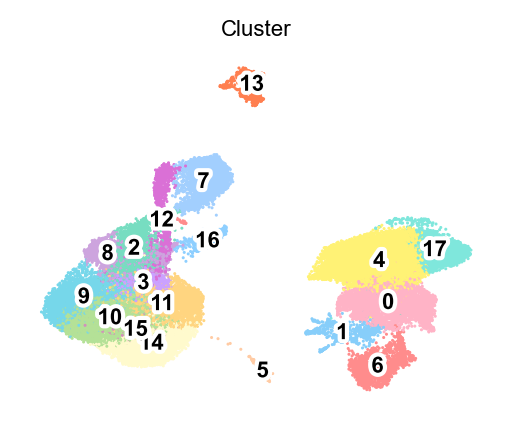

In [ ]:
margin_right = 0

fig_width = margin_left + plot_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_clean_v1,
    basis="X_umap",
    color="leiden",
    palette=leiden_colors_pastel,
    ax=axes,
    title="Cluster",
    legend_loc="on data",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

### c) Timepoint UMAP

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


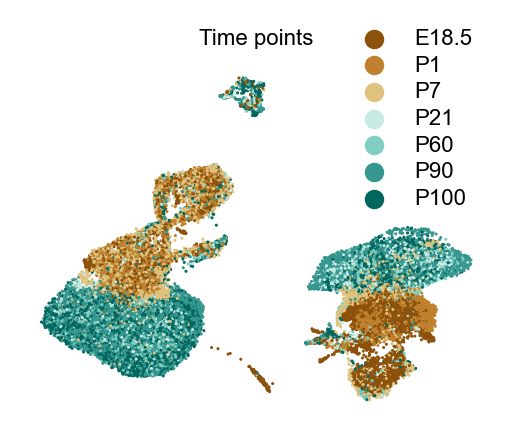

In [ ]:
# margin_right = (
#     20 / 25.4
# )  # Calculated separately down below after first generating the plot to keep space for the legend

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)  # Added extra space for the legend
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_clean_v1,
    basis="X_umap",
    color="timepoint",
    palette=timepoint_colors,
    ax=axes,
    title="Time points",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.get_legend().remove()

axes.legend(
    handles,
    labels,
    loc="upper right",
    frameon=False,
    bbox_to_anchor=(1, 1.15),
    labelspacing=0.3,
)

### Cell type

In [ ]:
cell_type_order = [
    "DETC",
    "DETC cycling",
    "LC",
    "LC cycling",
    "ILC",
    "NK cells",
    "Mast cells",
    "Epithelial cells",
]

adata_clean_v1.obs["cell_type"] = (
    adata_clean_v1.obs["cell_type"]
    .astype("category")
    .cat.reorder_categories(cell_type_order)
)

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Text(0.3, 1.0, 'Cell type')

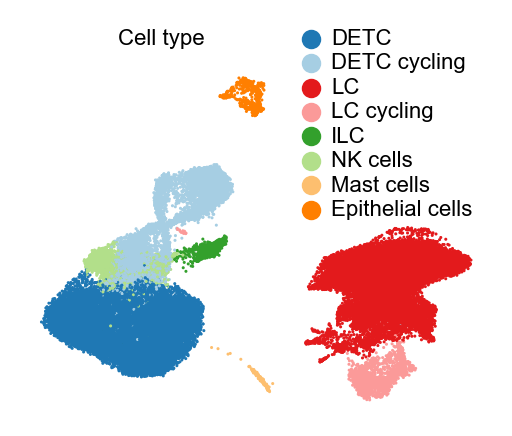

In [ ]:
margin_right = 0  # Calculated separately down below after first generating the plot to keep space for the legend

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)  # Added extra space for the legend
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_clean_v1,
    basis="X_umap",
    color="cell_type",
    palette=cell_type_colors,
    ax=axes,
    title="",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.get_legend().remove()

axes.legend(
    handles,
    labels,
    loc="upper right",
    frameon=False,
    bbox_to_anchor=(1, 1.15),
    labelspacing=0.2,
    handletextpad=-0.1,
)
axes.set_title("Cell type", x=0.3)

## Dotplot

In [ ]:
gene_sets_ordered = {
    "LC": ["Cd207", "Csf1r", "Epcam", "Itgam"],
    "DETC": [
        "Cd3e",
        "Tcrg-V5",
        "Trdv4",
    ],
    "other\nγδ-T-cells": ["Trdc", "Tcrg-V4", "Trdv2-2"],
    "Cycling": ["Mki67", "Top2a", "Mcm2", "Ube2c"],
    "Mast\ncells": ["Cpa3", "Hdc", "Tpsb2"],
    "ILC": ["Rora", "Il7r"],
    "NK cells": [
        "Klrd1",
        "Klrb1c",
        "Ncr1",
        "Itga1",
    ],
    "Epithelial\ncells": ["Lgals7", "Krt14", "Krt5"],
}

order_cluster = [
    "0",
    "1",
    "4",
    "17",
    "6",
    "2",
    "3",
    "7",
    "9",
    "10",
    "11",
    "12",
    "15",
    "14",
    "5",
    "16",
    "8",
    "13",
]

<positron-console-cell-39>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<positron-console-cell-39>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


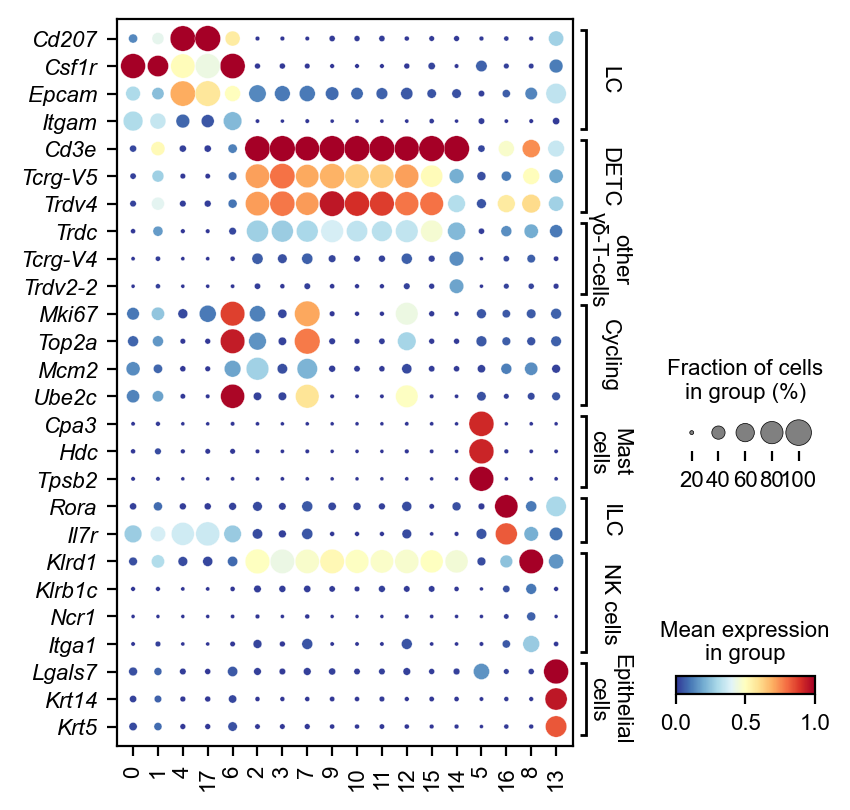

In [ ]:
fig, ax_dotplot = plot_dotplot(
    adata_clean_v1,
    genes=gene_sets_ordered,
    groupby="leiden",
    categories_order=order_cluster,
    swap_axes=True,
    figsize=(105 / 25.4, 100 / 25.4),
    dot_sizes=(2, 85),
    legend_size=(1.2, 0.2),
    legend_wspace=0.1,
    margin_dotplot=(-0.01, -0.02),
)

## Barplots

### Cycling

Text(0.5, 0, '')

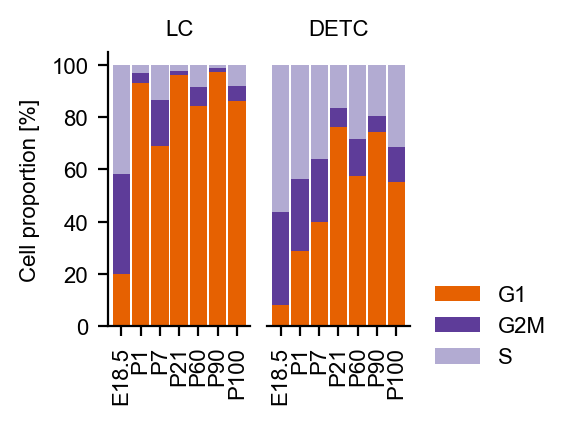

In [ ]:
timepoint_order = ["E18.5", "P1", "P7", "P21", "P60", "P90", "P100"]

df_lc = get_dataframe_barplot(
    adata_clean_v1[adata_clean_v1.obs["cell_type"].isin(["LC", "LC cycling"])],
    groupby="timepoint",
    color_var="phase",
    normalize_groupby=True,
    normalize_color_var=False,
    percent=True,
).reindex(timepoint_order)

df_detc = get_dataframe_barplot(
    adata_clean_v1[adata_clean_v1.obs["cell_type"].isin(["DETC", "DETC cycling"])],
    groupby="timepoint",
    color_var="phase",
    normalize_groupby=True,
    normalize_color_var=False,
    percent=True,
).reindex(timepoint_order)

fig = plt.figure(
    figsize=(fig_width + (10 / 25.4), fig_height), dpi=200, layout="constrained"
)

gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[10, 10, 2], wspace=0.05)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax_legend = fig.add_subplot(gs[0, 2])

df_lc.plot.bar(
    stacked=True,
    title="",
    color=phase_colors,
    width=0.9,
    ax=ax1,
    legend=False,
)

df_detc.plot.bar(
    stacked=True,
    title="",
    color=phase_colors,
    width=0.9,
    ax=ax2,
)

handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()

ax_legend.legend(
    handles=handles,
    labels=labels,
    loc="center right",
    bbox_to_anchor=(4, 0),
    borderaxespad=0,
    frameon=False,
)
ax_legend.axis("off")

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_yticklabels([])
ax2.set_yticks([])

ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=90,
    ha="center",
)
ax2.set_xticklabels(
    ax2.get_xticklabels(),
    rotation=90,
    ha="center",
)

ax1.set_xlabel("")
ax1.set_ylabel(
    "Cell proportion [%]",
)
ax1.set_title(
    "LC",
)
ax2.set_title(
    "DETC",
)
ax2.set_xlabel("")

# Subsetting and saving

We are saving DETCs and LCs separately to use in later analysis.

In [41]:
# detc = adata_clean_v1[adata_clean_v1.obs['leiden'].isin(['2', '3', '7', '9', '10', '11', '12', '15'])].copy()

# lc = adata_clean_v1[adata_clean_v1.obs['leiden'].isin(['0', '1', '4', '6', '17'])].copy()

In [ ]:
# detc.write_h5ad(f"{data_path}detc_uncleaned.h5ad")
# lc.write_h5ad(f"{data_path}lc_uncleaned.h5ad")